In [ ]:
(-0.00798403, -0.00598802), (7.96809574e-06, 1.19521436e-05)

x ** (s - 1) * np.exp(-0.5 * x ** 2 / a - 0.5 * p ** 2 * x ** (-2) / b)

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [75]:
def integrand1(x, s, a=7.96809574e-06, b=1.19521436e-05, p=0.00019306977288832455):
    return x ** (s - 1) * np.exp(-0.5 * x ** 2 / a - 0.5 * p ** 2 * x ** (-2) / b) / 3.310491898317922e+22

In [76]:
m = 0
n = 15
s = 2 * m - n

x = linspace(0.008, 0.03, 500)
y = [integrand1(_, s = s) for _ in x]

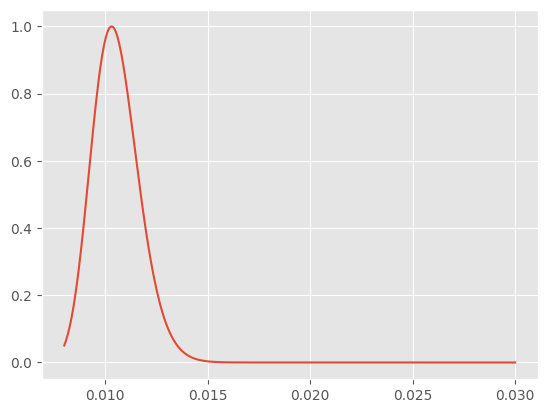

In [77]:
plot(x, y)
# vlines(0.010310017671626957, 0, 4e22, colors = 'k')

In [89]:
from scipy.integrate import quad
tmp = quad(
    integrand1,
    0,
    1,
    args=(s, ),
    limit=1000,
    epsabs=1e-30,
    epsrel=1e-10
)

In [90]:
tmp[1] * 3.310491898317922e+22

431705885.0284369

In [70]:
from sympy.solvers import solve
from sympy.abc import x, p, s, a, b

expr = (s - 1) + (p ** 2 / b * x ** (-2) - x ** 2/ a)
res = solve((s - 1) + (p ** 2 / b * x ** (-2) - x ** 2/ a), x)

In [71]:
expr = res[3]
expr

sqrt(2)*sqrt(a*s - a + sqrt(a**2*b**2*s**2 - 2*a**2*b**2*s + a**2*b**2 + 4*a*b*p**2)/b)/2

In [72]:
out = [_.subs([[a, 7.96809574e-06], [b, 1.19521436e-05], [s, -15], [p, 0.00019306977288832455]]) for _ in res]
out

[-0.0108117065311*sqrt(2)*I,
 0.0108117065311*sqrt(2)*I,
 -0.00729028340976056*sqrt(2),
 0.00729028340976056*sqrt(2)]

In [73]:
float(out[-1])

0.010310017671626957

In [74]:
integrand1(float(out[-1]), -15)

3.310491898317922e+22